In [1]:
! pip install gensim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

In [3]:
import pandas as pd
import numpy as np
import pandas as pd
import tensorflow as tf
import string
import re
import random
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import word2vec, FastText
import gensim.downloader
from sklearn.decomposition import PCA

In [4]:
df=pd.read_csv('/content/drive/MyDrive/ner_dataset.csv', encoding= 'unicode_escape')

In [5]:
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [6]:
# handle the missing values in the 'Sentence #' column
df['Sentence #']=df['Sentence #'].ffill()

In [7]:
# renaming of columns
df=df[['Sentence #','Word','Tag']]
df.rename(columns={'Sentence #':'Sentence','Word':'Token','Tag':'POS'},inplace=True)

<ipython-input-7-e86d625d88d5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Sentence #':'Sentence','Word':'Token','Tag':'POS'},inplace=True)


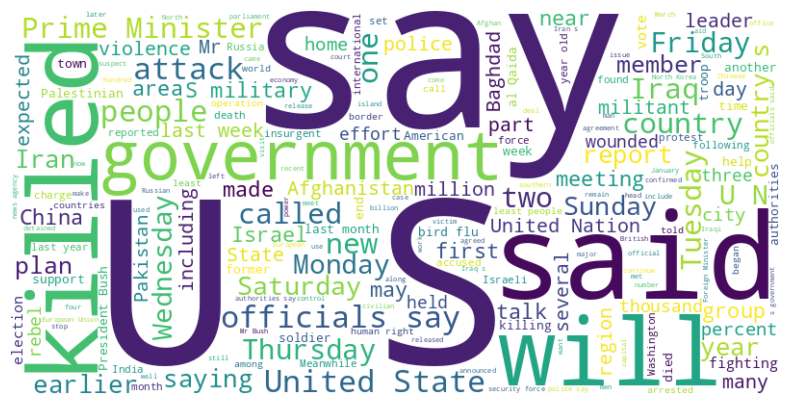

In [10]:
# wordcloud
text_data = " ".join(message for message in df['Token'])
# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, random_state=42, background_color='white').generate(text_data)
# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Clearly there is imbalance in the dataset. Person, Other and loc has the highest count compare to other tags. We will take care of that in loss

In [11]:
# dataset info
df.info() #There seems to be no null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   Sentence  1048575 non-null  object
 1   Token     1048575 non-null  object
 2   POS       1048575 non-null  object
dtypes: object(3)
memory usage: 24.0+ MB


In [12]:
# checking for unique values
print('Number of sentences are '+str(df['Sentence'].nunique()))
print('Number of Vocabs are '+str(df['Token'].nunique()))

Number of sentences are 47959
Number of Vocabs are 35178


## Data Pre-processing

In [13]:
import xml.etree.ElementTree as ET
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import gensim.downloader as api
from tensorflow.keras.layers import Embedding

tf.random.set_seed(123)

In [15]:
# turning the tokens to lower case
df['Token']=df['Token'].str.lower()

In [17]:
# grouping by sentence
sentence_all = [(list(zip(group['Token'], group['POS']))) for _, group in df.groupby('Sentence')]

In [13]:
sentence_all[0] #1st Sentence

[('thousands', 'O'),
 ('of', 'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('london', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('british', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]

In [18]:
# Establishing Hyperparameters
if tf.test.is_gpu_available():
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 20

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [19]:
! pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 689.3 kB/s eta 0:00:00


In [20]:
# Extracting unique words from the 'Token' column of the DataFrame and converting them into a list.
words = list(set(df['Token'].values))
# Extracting unique Part of Speech (POS) tags from the 'POS' column of the DataFrame and converting them into a list.
tags = list(set(df["POS"].values))

In [21]:
#Creating word to index and tag to index
import sklearn

# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}


In [22]:
# Embedding the word matrix, we will add this
hits = 0
misses = 0
word2vec = api.load("word2vec-google-news-300")
embedding_dim = 300

# Prepare embedding matrix
embedding_matrix = np.zeros((len(word2idx), embedding_dim))
for word, i in zip(word2idx.keys(),word2idx.values()):
    embedding_vector = None
    try:
      embedding_vector = word2vec[word]
    except Exception :
      pass

    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Converted 19600 words (12219 misses)


In [23]:
#Tagging word to index and tag to index
from keras_preprocessing.sequence import pad_sequences

# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentence_all]

# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

# Convert Tag/Label to tag_index
y = [[tag2idx[w[1]] for w in s] for s in sentence_all]

# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=75, sequences=y, padding="post", value=tag2idx["PAD"])
from keras.utils import to_categorical

# One-Hot encode
y = [to_categorical(i, num_classes=len(tags)+1) for i in y]  # n_tags+1(PAD)
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

print('Raw Sample:\n ', ' '.join([w[0] for w in sentence_all[1]]))
print('\n ' )
print('Raw Label:\n ', ' '.join([w[1] for w in sentence_all[1]]))
print('\n ' )
print('After processing, sample:\n', X[0])
print('\n ' )
print('After processing, labels:\n', y[0])

Raw Sample:
  iranian officials say they expect to get access to sealed sensitive parts of the plant wednesday , after an iaea surveillance system begins functioning .

 
Raw Label:
  B-gpe O O O O O O O O O O O O O O B-tim O O O B-org O O O O O

 
After processing, sample:
 [22442 19702  8621 29140  4928 29908 26718  4972  4324 31717 17607 17717
 29249  9286 29544 31717  2732 19702 21995 31446 28269 31202 25482  8527
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]

 
After processing, labels:
 [[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [24]:
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

((43163, 75), (4796, 75), (43163, 75, 18), (4796, 75, 18))

In [25]:
y_tr = np.array(y_tr)
y_te = np.array(y_te)

## Model Building

In [26]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.8 MB/s eta 0:00:00


In [27]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow_addons.utils.types import FloatTensorLike, TensorLike
from tensorflow_addons.layers import CRF
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow_addons.optimizers import AdamW

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [38]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow_addons.utils.types import FloatTensorLike, TensorLike
from tensorflow_addons.layers import CRF
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow_addons.optimizers import AdamW



def build_model(max_len = 75, input_dim = len(word2idx),embedding_dim = 300):
  # Model definition
  input = Input(shape=(max_len,))

  # Get embeddings
  embeddings = Embedding(
      input_dim,
      embedding_dim,
      weights=[embedding_matrix],
    input_length=max_len,
       mask_zero=True,
    trainable=True,
      name = 'embedding_layer'
  )(input)

  # variational biLSTM
  output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(embeddings)
  output_sequences = Bidirectional(LSTM(units=100, return_sequences=True))(output_sequences)
  # Stacking
  output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(output_sequences)

  # Adding more non-linearity
  dense_out = TimeDistributed(Dense(25, activation="relu"))(output_sequences)

  # CRF layer
  mask = Input(shape=(max_len,), dtype=tf.bool)
  crf = CRF(18, name='crf')
  predicted_sequence, potentials, sequence_length, crf_kernel = crf(dense_out)

  model = Model(input, potentials)
  model.compile(
      optimizer=AdamW(weight_decay=0.001),
      loss= SigmoidFocalCrossEntropy()) # Sigmoid focal cross entropy loss

  return model

model = build_model()

# Checkpointing
save_model = tf.keras.callbacks.ModelCheckpoint(filepath='ner_crf.h5',
  monitor='val_loss',
  save_weights_only=True,
  save_best_only=True,
  verbose=1
)

# Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=10)

callbacks = [save_model, es]

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 75)]              0         
                                                                 
 embedding_layer (Embedding  (None, 75, 300)           9545700   
 )                                                               
                                                                 
 bidirectional_8 (Bidirecti  (None, 75, 100)           140400    
 onal)                                                           
                                                                 
 bidirectional_9 (Bidirecti  (None, 75, 200)           160800    
 onal)                                                           
                                                                 
 bidirectional_10 (Bidirect  (None, 75, 100)           100400    
 ional)                                                    

## Model Evaluation

In [ ]:
# Train the model using the fit method
history = model.fit(
  # Training data input (X_tr)
  X_tr,
  # Training data labels (y_tr)
  y_tr,
  # Batch size for training
  batch_size=64,
  # Number of training epochs
  epochs=20,
  # Validation data to evaluate model performance during training
  validation_data=(X_te, y_te),
  # Callbacks for monitoring and modifying training behavior
  callbacks=callbacks,
  # Shuffle the training data at the beginning of each epoch
  shuffle=True
)

Epoch 1/20


589/675 [=========================>....] - ETA: 2:04 - loss: 0.2076

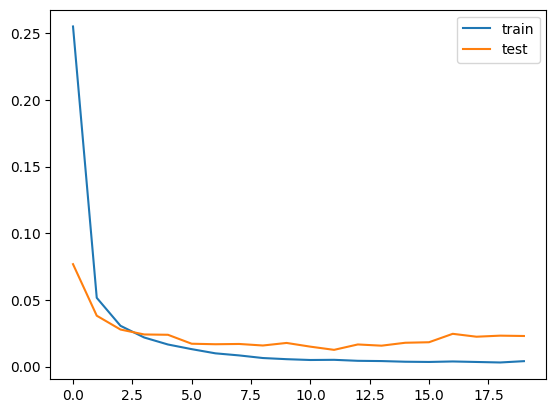

In [28]:
# Plotting the validation loss over epochs
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Since it's still reducing there is a chance it will reduce more with more hyperparam tuning but loss of 0.02 for train and 0.14 with test looks great

150/150 [==============================] - 28s 111ms/step


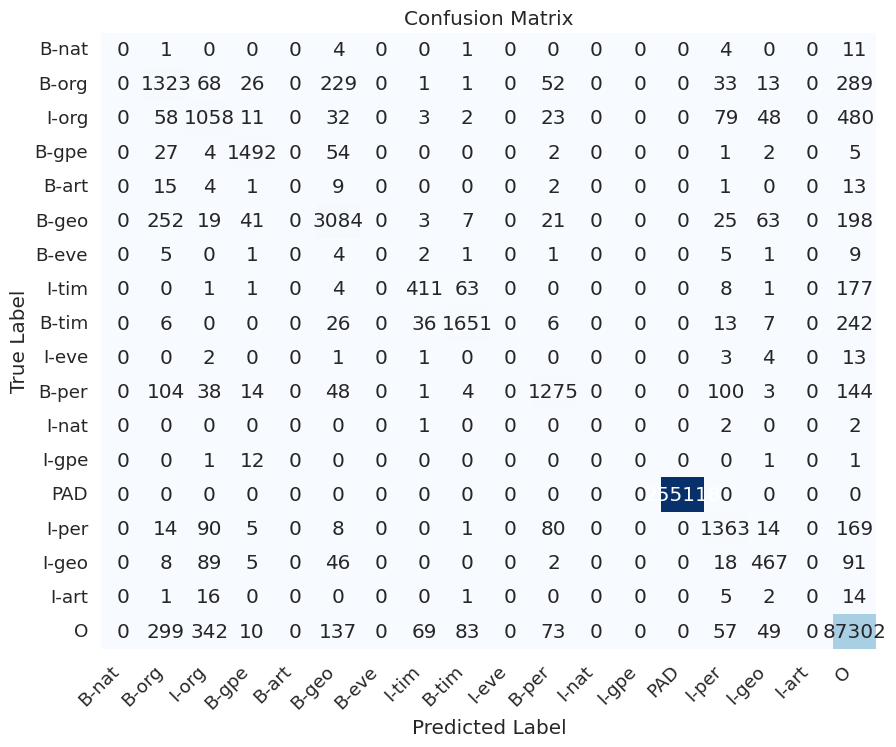

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Making predictions on the test set
predictions = model.predict(X_te)

# Converting predictions to POS tags
predicted_tags = np.argmax(predictions, axis=-1)
predicted_tags = [[idx2tag[tag] for tag in sample] for sample in predicted_tags]

# Flattening the predicted and true POS tag sequences
flatten_predicted = [tag for sample in predicted_tags for tag in sample]
flatten_true = [idx2tag[np.argmax(tag)] for sample in y_te for tag in sample]

# Getting unique tags from the true and predicted sequences
unique_tags = list(set(flatten_true + flatten_predicted))

# Computing the confusion matrix
cm = confusion_matrix(flatten_true, flatten_predicted, labels=unique_tags)

# Creating a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=unique_tags, columns=unique_tags)

# Setting up the plot
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)

# Plotting the confusion matrix as a heatmap
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d", cbar=False)

# Customizing the plot
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

# Show the plot
plt.show()


In [ ]:
from sklearn.metrics import classification_report
print("Classification Report:\n ", classification_report(flatten_predicted, flatten_true, labels=unique_tags))